In [1]:
import pandas as pd
import numpy as np
import scipy

from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery as bq

%matplotlib inline

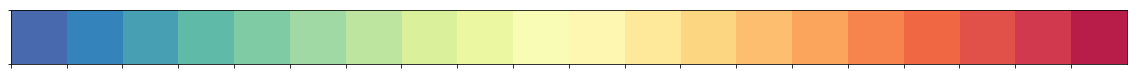

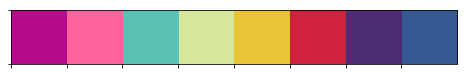

In [2]:
sns.palplot(sns.color_palette("Spectral_r", n_colors=20))
sns.palplot(sns.color_palette(["#b7098b","#ff639c", "#5bc1b5", "#d6e79a", "#eac435", "#d0213e", "#4c2c72", "#345995"]))

In [3]:
hormone_expression_bigtable = pd.read_table("./datasets/hormone_expression_bigtable.IlluminaHiSeq.tsv", sep="\t")

print(hormone_expression_bigtable.shape)
hormone_expression_bigtable.head()

(53970, 19)


,case_barcode,sample_barcode,aliquot_barcode,gene_symbol,normalized_count,transformed_count,sample_type,sample_type_name,initial_response,recurrence_status,recurrence_log,subtype,ER,PR,Her2_IHC,Her2_ISH,Her2,triple_negative,subtype_sub
0,TCGA-5L-AAT0,TCGA-5L-AAT0-01A,TCGA-5L-AAT0-01A-12R-A41B-07,ADRA2C,39.8885,5.353623,1,Primary solid Tumor,Unknown,NaN,NaN,LumA,Positive,Positive,1+,NaN,NaN,NaN,LumA
1,TCGA-5L-AAT0,TCGA-5L-AAT0-01A,TCGA-5L-AAT0-01A-12R-A41B-07,ANP32E,766.0947,9.583261,1,Primary solid Tumor,Unknown,NaN,NaN,LumA,Positive,Positive,1+,NaN,NaN,NaN,LumA
2,TCGA-5L-AAT0,TCGA-5L-AAT0-01A,TCGA-5L-AAT0-01A-12R-A41B-07,ARL4C,993.6941,9.958109,1,Primary solid Tumor,Unknown,NaN,NaN,LumA,Positive,Positive,1+,NaN,NaN,NaN,LumA
3,TCGA-5L-AAT0,TCGA-5L-AAT0-01A,TCGA-5L-AAT0-01A-12R-A41B-07,ASCL1,0.0000,0.000000,1,Primary solid Tumor,Unknown,NaN,NaN,LumA,Positive,Positive,1+,NaN,NaN,NaN,LumA
4,TCGA-5L-AAT0,TCGA-5L-AAT0-01A,TCGA-5L-AAT0-01A-12R-A41B-07,ASS1,673.4125,9.397487,1,Primary solid Tumor,Unknown,NaN,NaN,LumA,Positive,Positive,1+,NaN,NaN,NaN,LumA


In [4]:
print("Sample types")
print(hormone_expression_bigtable.drop_duplicates(subset="sample_barcode").sample_type_name.value_counts())
print("\n")

print("Initial responses")
print(hormone_expression_bigtable.drop_duplicates(subset="case_barcode").initial_response.value_counts())
print("\n")

print("Recurrence statuses")
print(hormone_expression_bigtable.drop_duplicates(subset="case_barcode").recurrence_status.value_counts())

Sample types
Primary solid Tumor    480
Solid Tissue Normal     33
Metastatic               1
Name: sample_type_name, dtype: int64


Initial responses
Unknown               431
Complete response      40
Progressive/Stable      9
Name: initial_response, dtype: int64


Recurrence statuses
Unknown     423
Occured      42
Low risk      8
Name: recurrence_status, dtype: int64


In [5]:
expression_matrix = hormone_expression_bigtable.pivot(index='gene_symbol', columns='aliquot_barcode', 
                                                      values='transformed_count')

print(expression_matrix.shape)
expression_matrix.head()

(105, 514)


aliquot_barcode,TCGA-5L-AAT0-01A-12R-A41B-07,TCGA-5L-AAT1-01A-12R-A41B-07,TCGA-5T-A9QA-01A-11R-A41B-07,TCGA-A1-A0SF-01A-11R-A144-07,TCGA-A1-A0SQ-01A-21R-A144-07,TCGA-A2-A04N-01A-11R-A115-07,TCGA-A2-A04R-01A-41R-A109-07,TCGA-A2-A04V-01A-21R-A034-07,TCGA-A2-A04X-01A-21R-A034-07,TCGA-A2-A04Y-01A-21R-A034-07,...,TCGA-S3-A6ZH-01A-22R-A32P-07,TCGA-S3-AA0Z-01A-11R-A41B-07,TCGA-S3-AA11-01A-31R-A41B-07,TCGA-S3-AA12-01A-11R-A41B-07,TCGA-S3-AA17-01A-11R-A41B-07,TCGA-V7-A7HQ-01A-11R-A33J-07,TCGA-W8-A86G-01A-21R-A36F-07,TCGA-WT-AB41-01A-11R-A41B-07,TCGA-WT-AB44-01A-11R-A41B-07,TCGA-XX-A899-01A-11R-A36F-07
gene_symbol,,,,,,,,,,,,,,,,,,,,,
ADRA2C,5.353623,5.034955,8.948954,7.585473,4.197512,5.412802,1.061223,4.444813,3.688751,7.507771,...,5.335104,2.696283,6.970269,1.565500,6.750738,7.721103,6.547644,9.522046,5.137868,6.085958
ANP32E,9.583261,9.108360,6.086308,10.008464,10.175954,9.372962,11.066019,10.669437,8.792080,10.828133,...,11.234595,12.717716,9.483399,9.273418,9.429852,8.734465,9.307549,10.252020,9.942660,10.109748
ARL4C,9.958109,11.198834,7.288494,9.284177,8.181195,9.943622,8.949372,9.345226,9.395779,10.203331,...,9.326900,10.493760,8.256225,8.177847,10.446850,9.452429,9.865936,10.910269,9.778429,10.338403
ASCL1,0.000000,4.417846,4.762912,0.000000,7.711308,0.000000,0.000000,0.859811,2.085459,8.160099,...,0.000000,0.425030,0.000000,2.435522,5.553729,2.567229,0.000000,7.767370,0.000000,0.478920
ASS1,9.397487,10.356120,8.859190,9.084624,9.431415,10.309732,7.438101,8.386607,11.492383,12.477313,...,7.322312,11.420115,11.488817,4.463897,9.491997,12.288174,10.589305,8.588975,10.102970,12.120552


In [6]:
labels_aliquots = {}

labels_aliquots["Normal"] = list(hormone_expression_bigtable.loc[hormone_expression_bigtable['sample_type'] == 11, 
                                                           'aliquot_barcode'].unique())

labels_aliquots["Complete response"] = list(hormone_expression_bigtable.loc[
                                            (hormone_expression_bigtable['sample_type'] == 1) &
                                            (hormone_expression_bigtable['initial_response'] == 'Complete response'), 
                                            'aliquot_barcode'].unique())

labels_aliquots["Progressive/Stable"] = list(hormone_expression_bigtable.loc[
                                            (hormone_expression_bigtable['sample_type'] == 1) & 
                                            (hormone_expression_bigtable['initial_response'] == 'Progressive/Stable'), 
                                            'aliquot_barcode'].unique())

labels_aliquots["Recurrence occured"] = list(hormone_expression_bigtable.loc[
                                            (hormone_expression_bigtable['sample_type'] == 1) & 
                                            (hormone_expression_bigtable['recurrence_status'] == 'Occured'), 
                                            'aliquot_barcode'].unique())

labels_aliquots["Low-risk recurrence"] = list(hormone_expression_bigtable.loc[
                                            (hormone_expression_bigtable['sample_type'] == 1) & 
                                            (hormone_expression_bigtable['recurrence_status'] == 'Low risk'), 
                                            'aliquot_barcode'].unique())

for k, v in labels_aliquots.items():
    print("{}: {}".format(k, len(v)))

Normal: 33
Complete response: 40
Progressive/Stable: 9
Recurrence occured: 42
Low-risk recurrence: 8


# Initial response

In [7]:
select = [item for key in ['Normal', 'Complete response', 'Progressive/Stable'] for item in labels_aliquots[key]]
expression_matrix = expression_matrix.loc[:,select]
expression_matrix.sort_values(by=select, inplace=True)

df = pd.concat([expression_matrix.loc[:, labels_aliquots['Normal']].sort_values(by=list(expression_matrix.index), axis=1), 
                expression_matrix.loc[:, labels_aliquots['Complete response']].sort_values(by=list(expression_matrix.index), axis=1), 
                expression_matrix.loc[:, labels_aliquots['Progressive/Stable']].sort_values(by=list(expression_matrix.index), axis=1)],
               axis=1)
expression_matrix = df

expression_matrix.shape

(105, 82)

In [8]:
print(expression_matrix.min().min())
print(expression_matrix.max().max())

0.0
17.9246517870353


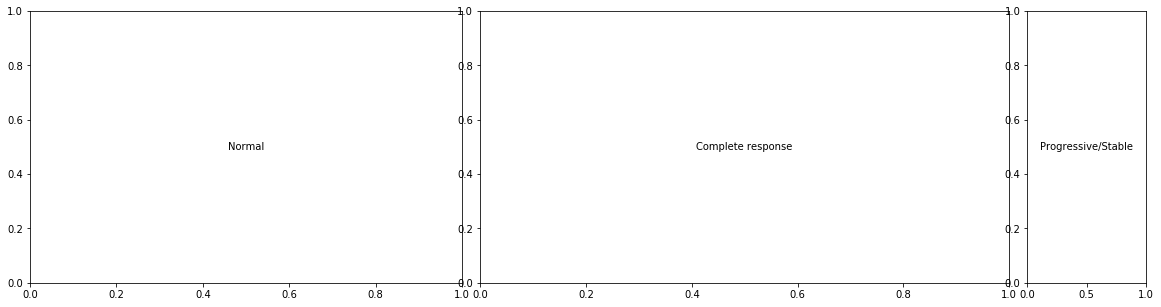

In [9]:
grid_kws = {"width_ratios": (0.40, 0.49, 0.11), "wspace": 0.05}
fig, axes = plt.subplots(1, 3, figsize=(20,5), gridspec_kw=grid_kws)

for label, ax in zip(['Normal', 'Complete response', 'Progressive/Stable'], axes):
    ax.text(0.5, 0.5, label, va="center", ha="center")

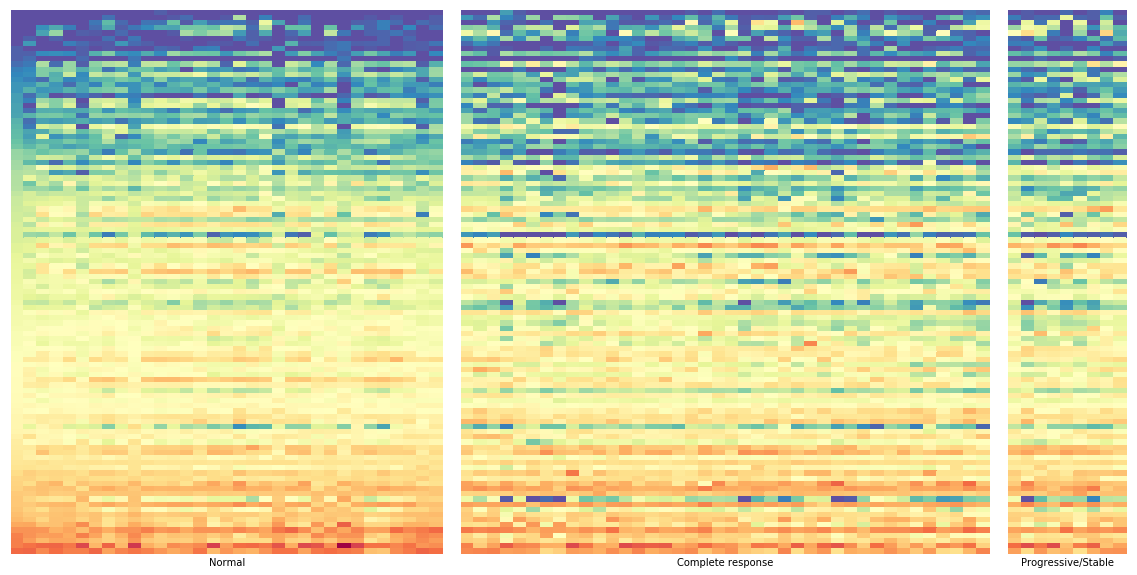

In [10]:
grid_kws = {"width_ratios": (0.40, 0.49, 0.11), "wspace": 0.05}
fig, axes = plt.subplots(1, 3, figsize=(20,10), gridspec_kw=grid_kws)

for label, ax in zip(['Normal', 'Complete response', 'Progressive/Stable'], axes):
    sns.heatmap(data=expression_matrix.loc[:, labels_aliquots[label]], 
                cmap="Spectral_r", vmin=0, vmax=18, 
                ax=ax, cbar=False, 
                xticklabels=False, yticklabels=False)
    ax.set_ylabel('')    
    ax.set_xlabel(label)

In [11]:
fig.savefig("./plots/expressiondata.hormone.initial_response.png", bbox_inches = 'tight', transparent=True)

# Recurrence status

In [7]:
select = [item for key in ['Normal', 'Recurrence occured', 'Low-risk recurrence'] for item in labels_aliquots[key]]
expression_matrix = expression_matrix.loc[:,select]
expression_matrix.sort_values(by=select, inplace=True)

df = pd.concat([expression_matrix.loc[:, labels_aliquots['Normal']].sort_values(by=list(expression_matrix.index), axis=1), 
                expression_matrix.loc[:, labels_aliquots['Recurrence occured']].sort_values(by=list(expression_matrix.index), axis=1), 
                expression_matrix.loc[:, labels_aliquots['Low-risk recurrence']].sort_values(by=list(expression_matrix.index), axis=1)],
               axis=1)
expression_matrix = df

expression_matrix.shape

(105, 83)

In [8]:
print(expression_matrix.min().min())
print(expression_matrix.max().max())

0.0
17.9246517870353


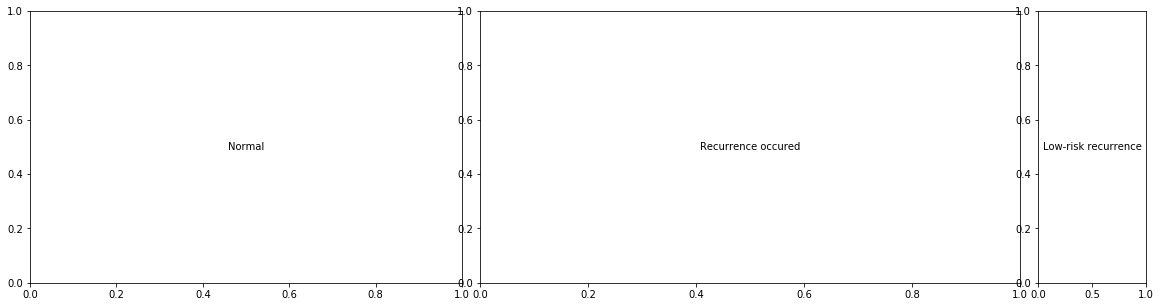

In [9]:
grid_kws = {"width_ratios": (0.4, 0.5, 0.1), "wspace": 0.05}
fig, axes = plt.subplots(1, 3, figsize=(20,5), gridspec_kw=grid_kws)

for label, ax in zip(['Normal', 'Recurrence occured', 'Low-risk recurrence'], axes):
    ax.text(0.5, 0.5, label, va="center", ha="center")

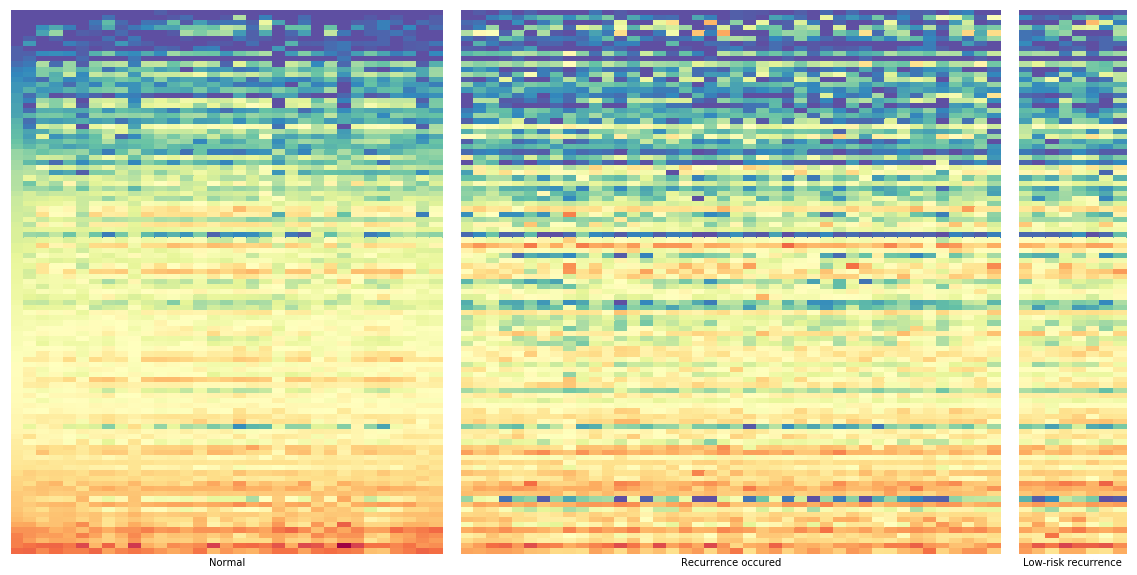

In [10]:
grid_kws = {"width_ratios": (0.4, 0.5, 0.1), "wspace": 0.05}
fig, axes = plt.subplots(1, 3, figsize=(20,10), gridspec_kw=grid_kws)

for label, ax in zip(['Normal', 'Recurrence occured', 'Low-risk recurrence'], axes):
    sns.heatmap(data=expression_matrix.loc[:, labels_aliquots[label]], 
                cmap="Spectral_r", vmin=0, vmax=18, 
                ax=ax, cbar=False, 
                xticklabels=False, yticklabels=False)
    ax.set_ylabel('')    
    ax.set_xlabel(label)

In [11]:
fig.savefig("./plots/expressiondata.hormone.recurrence_status.png", bbox_inches = 'tight', transparent=True)